In [1]:
import numpy as np
import os
import sys
parent_path=os.path.dirname(os.getcwd())
sys.path.append(parent_path+'/src')


from reaction_data import get_graph_data

rsmi_list = ['CCOC(C)=O.COCCOc1ccc(CCCN)c(Oc2ncc(C(F)(F)F)cc2Cl)c1.Cl.O=S(=O)(Cl)c1ccccc1Cl.c1ccncc1>>COCCOc1ccc(CCCNS(=O)(=O)c2ccccc2Cl)c(Oc2ncc(C(F)(F)F)cc2Cl)c1']
rmol_max_cnt = np.max([smi.split(">>")[0].count(".") + 1 for smi in rsmi_list])
pmol_max_cnt = np.max([smi.split(">>")[1].count(".") + 1 for smi in rsmi_list])

a,b,c=get_graph_data(rsmi_list,rmol_max_cnt, pmol_max_cnt)

c:\Users\chung\anaconda3\envs\syncat\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- generating graph data for None
--- n_reactions: 1, reactant_max_cnt: 5, product_max_cnt: 1


In [2]:
from data import GraphDataset

d=GraphDataset(save_path=None,rmol = a, pmol= b, reaction= c)

In [3]:
from torch.utils.data import DataLoader
from utils import collate_reaction_graphs
loader = DataLoader(
    dataset=d,
    batch_size=int(np.min([32,len(d)])),
    shuffle=False,
    collate_fn=collate_reaction_graphs,
)

In [4]:
node_dim = d.rmol_node_attr[0].shape[1]
edge_dim = d.rmol_edge_attr[0].shape[1]
print(node_dim)
print(edge_dim)

155
9


In [6]:
from model import model
import torch

device= (torch.device("cuda:0") if torch.cuda.is_available()
         else torch.device("cpu"))
print(device)

cpu


In [7]:
net=model(node_dim, edge_dim, 1000, 3, 384, 0.1).to(device)
model_path=('../Data/model/model_tpl.pt')
checkpoint=torch.load(model_path, weights_only=False, map_location=device )
net.load_state_dict(checkpoint["model_state_dict"])


<All keys matched successfully>

In [8]:
from tqdm import tqdm
net.eval()
with torch.no_grad():
    for batchdata in tqdm(loader,desc='prediction'):
        rmol = [b.to(device) for b in batchdata[:rmol_max_cnt]]
        pmol = [b.to(device) for b in batchdata[rmol_max_cnt:rmol_max_cnt+pmol_max_cnt]]
        r_dummy = batchdata[-4]
        p_dummy = batchdata[-3]

        pred, att_r, att_p, emb = net(rmol, pmol, r_dummy, p_dummy, device)



prediction:   0%|          | 0/1 [00:00<?, ?it/s]d:\workspace\SynCat/src\data.py:118: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  r_edge_index = torch.tensor([r_src, r_dst], dtype=torch.long)
prediction: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


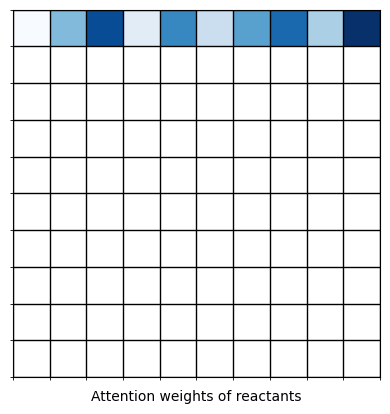

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_1d_heatmap(values, cmap='Blues', colorbar=True,x_label='Attention weights of reactants'):
    """
    Plots a 1D heatmap for a list of values in the range [0, 1].
    
    Args:
        values (list or array-like): List of numeric values between 0 and 1.
        cmap (str): Colormap to use (default 'viridis').
        figsize (tuple): Size of the plot.
        colorbar (bool): Whether to show the colorbar.
        title (str): Title of the plot.
    """
    heatmap_data = np.array([values])
    plt.figure(figsize=(4, len(values)))
    img = plt.imshow(heatmap_data, aspect=1, cmap=cmap)
    # if colorbar:
    #     plt.colorbar(img, label='Value')
    plt.yticks([])
    plt.xticks([])
    plt.xticks(np.arange(len(values) + 1) - 0.5, minor=True)
    plt.yticks(np.arange(len(values) + 1) - 0.5, minor=True)
    plt.grid(which="minor", color='black', linestyle='-', linewidth=1)
    plt.xlabel('Attention weights of reactants')
    plt.tight_layout()
    plt.show()

# Example usage:
values = [0.1, 0.5, 0.9, 0.2, 0.7, 0.3, 0.6, 0.8, 0.4, 1.0]
plot_1d_heatmap(values)


In [29]:
import itertools

def sum_related(values: list[float], N: int) -> list:
    """
    Calculate the sum of all entries in `values` that involve the variable at index `i`.

    The `values` list is organized as follows:
      - The first N elements (indices 0 to N-1) are the individual variable values.
      - The remaining elements (indices N to N + C(N,2) - 1) are the pairwise sums,
        ordered according to itertools.combinations(range(N), 2).

    Args:
        values (list[float]): A list of length N + C(N, 2), where C(N, 2) = N*(N-1)/2.
        N (int): The number of original variables.
        i (int): The index (0-based) of the target variable.

    Returns:
        float: The sum of values[i] plus all pairwise sums in `values` that include the variable at index `i`.

    Raises:
        ValueError: If the length of `values` does not match N + C(N, 2).
    """
    expected_len = N + (N * (N - 1)) // 2
    if len(values) != expected_len:
        raise ValueError(f"Expected list length {expected_len}, got {len(values)}")
    lst_att=[]
    for i in range(N):
        total = values[i]
        for idx, (a, b) in enumerate(itertools.combinations(range(N), 2)):
            if i in (a, b):
                total += values[N + idx]
        lst_att.append(total)
    return lst_att



In [34]:
N_r=rsmi_list[0].split(">>")[0].count(".") + 1
N_p=rsmi_list[0].split(">>")[1].count(".") + 1

In [35]:
lst_att_r = sum_related(att_r[0], N_r)
lst_att_p = sum_related(att_p[0],N_p)
print(lst_att_r)
print(lst_att_p)



[0.07960653444922627, 0.8837867295369506, 0.00535367798685682, 0.9440443819621578, 0.04711583334528768]
[1.0]


In [13]:
from rdkit.Chem import AllChem, Draw
def visual_reaction(rsmi):
    reaction=AllChem.ReactionFromSmarts(rsmi, useSmiles=True)
    return display(Draw.ReactionToImage(reaction))
